In [1]:
import numpy as np #imports numpy as np
import pandas as pd #imports pandas as pd
import matplotlib.pyplot as plt #for plotting
import warnings 
warnings.filterwarnings('ignore') #ignores warnings 
from sklearn.model_selection import train_test_split #for making train/test splits
import unicodedata #for normalizing/removing non ascii characters 
import re #for removing punctuations etc
import nltk #for tokenization, stepward removal, etc
import os #for using operating system directory
from nltk.tokenize import word_tokenize #for tokenizing into words 
from nltk.corpus import stopwords #for finding common stopwords
from nltk.stem import WordNetLemmatizer #transforms words into base form
from tensorflow.keras.preprocessing.text import Tokenizer #turns text into int sequences 
from tensorflow.keras.preprocessing.sequence import pad_sequences #makes sequences the same length 
from tensorflow.keras.models import Sequential #for nn layers 
from tensorflow.keras.layers import Embedding, Dense, Dropout #for embedding vectors, dense layers, and dropout
from tensorflow.keras.layers import LSTM, Bidirectional #long short term memory for nlp nn, and bidirectional layer
from tensorflow.keras.callbacks import EarlyStopping #stops early if no improvment over enochs 

In [2]:
amazon = pd.read_csv("/Users/smzerbe/Documents/sentiment labelled sentences/amazon_cells_labelled.txt", delimiter='\t', header=None) #Loads Amazon dataset with no tab seperation or header
imdb = pd.read_csv("/Users/smzerbe/Documents/sentiment labelled sentences/imdb_labelled.txt", delimiter='\t', header=None) #Loads IMDB dataset with no tab seperation or header
yelp = pd.read_csv("/Users/smzerbe/Documents/sentiment labelled sentences/yelp_labelled.txt", delimiter='\t', header=None) #Loads Yelp dataset with no tab seperation or header

In [3]:
amazon.columns = imdb.columns = yelp.columns = ['review', 'label'] #names columns for 3 datasets 
df = pd.concat([amazon, imdb, yelp], ignore_index=True) #combines datasets into one dataframe

In [4]:
df['total_words'] = [len(x.split()) for x in df['review'].tolist()] #makes a column counting total words for each row
df['total_chars'] = df['review'].apply(len) #makes a column counting total characters for each row
df.info #give summary info on df

<bound method DataFrame.info of                                                  review  label  total_words  \
0     So there is no way for me to plug it in here i...      0           21   
1                           Good case, Excellent value.      1            4   
2                                Great for the jawbone.      1            4   
3     Tied to charger for conversations lasting more...      0           11   
4                                     The mic is great.      1            4   
...                                                 ...    ...          ...   
2743  I think food should have flavor and texture an...      0           12   
2744                           Appetite instantly gone.      0            3   
2745  Overall I was not impressed and would not go b...      0           10   
2746  The whole experience was underwhelming, and I ...      0           16   
2747  Then, as if I hadn't wasted enough of my life ...      0           28   

      total_chars  

In [5]:
df.head(10) #shows first 10 rows of df

,review,label,total_words,total_chars
0,So there is no way for me to plug it in here i...,0,21,82
1,"Good case, Excellent value.",1,4,27
2,Great for the jawbone.,1,4,22
3,Tied to charger for conversations lasting more...,0,11,79
4,The mic is great.,1,4,17
5,I have to jiggle the plug to get it to line up...,0,17,74
6,If you have several dozen or several hundred c...,0,21,111
7,If you are Razr owner...you must have this!,1,8,43
8,"Needless to say, I wasted my money.",0,7,35
9,What a waste of money and time!.,0,7,32


In [6]:
print(df['label'].value_counts()) #gives total count of positive (1) /negative (0) reviews 

label
1    1386
0    1362
Name: count, dtype: int64


In [7]:
non_ascii = df[df['review'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', x)))] #finds rows with non ascii characters
print(non_ascii) #shows rows with non ascii characters 

                                                 review  label  total_words  \
1018  It's practically perfect in all of them  a tr...      1           17   
1019   The structure of this film is easily the most...      0          865   
1117                The script iswas there a script?        0            7   
1121        I'll even say it again  this is torture.        0            9   
1226  This show is made for Americans - it is too st...      0           21   
1271  A cheap and cheerless heist movie with poor ch...      0           45   
1297  And I forgot: The Casting here i superb, with ...      1           33   
1319  The script is bad, very bad  it contains both...      0           24   
1359  Let's start with all the problemsthe acting, ...      0           16   
1562  Technically, the film is well made with impres...      1           35   
1569  I am so tired of clichés that is just lazy wri...      0           19   
1646   With great sound effects, and impressive spec

In [8]:
df['review'] = df['review'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')) #normalizes text with non ascii characters 

In [9]:
non_ascii = df[df['review'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', x)))] #checks for rows with non ascii characters post normalization
print(non_ascii) #shows rows with non ascii characters post normalization 

Empty DataFrame
Columns: [review, label, total_words, total_chars]
Index: []


In [10]:
print("Data shape:", df.shape) #shows number of rows and columns in df
print("Missing values:\n", df.isnull().sum()) #shows null values in columns
df.dropna(inplace=True) #drops any null values 

Data shape: (2748, 4)
Missing values:
 review         0
label          0
total_words    0
total_chars    0
dtype: int64


In [11]:
df['review'] = df['review'].str.lower() #changes text in review column to lowercase
df.head(10) #shows first 10 rows of df

,review,label,total_words,total_chars
0,so there is no way for me to plug it in here i...,0,21,82
1,"good case, excellent value.",1,4,27
2,great for the jawbone.,1,4,22
3,tied to charger for conversations lasting more...,0,11,79
4,the mic is great.,1,4,17
5,i have to jiggle the plug to get it to line up...,0,17,74
6,if you have several dozen or several hundred c...,0,21,111
7,if you are razr owner...you must have this!,1,8,43
8,"needless to say, i wasted my money.",0,7,35
9,what a waste of money and time!.,0,7,32


In [12]:
p = re.compile(r'[^\w\s]') #finds all characters that arents words or spaces (punctuation)
df['review'] = [p.sub(' ', x) for x in df['review'].tolist()] #replaces punctuation with space
df.head(10) #shows first 10 rows of df

,review,label,total_words,total_chars
0,so there is no way for me to plug it in here i...,0,21,82
1,good case excellent value,1,4,27
2,great for the jawbone,1,4,22
3,tied to charger for conversations lasting more...,0,11,79
4,the mic is great,1,4,17
5,i have to jiggle the plug to get it to line up...,0,17,74
6,if you have several dozen or several hundred c...,0,21,111
7,if you are razr owner you must have this,1,8,43
8,needless to say i wasted my money,0,7,35
9,what a waste of money and time,0,7,32


In [13]:
print(stopwords.words('english')) #shows english stopwords 

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [14]:
stop_words = set(stopwords.words('english')) #loads english stopwords 
data_set = [] #makes list for tokenized reviews  
for sentence in df['review']:
    data_set.append([word for word in word_tokenize(sentence) if word not in stop_words]) #tokenizes reveiws/removes stopwords
df['review'] = [' '.join(words) for words in data_set] #replaces review column with tokenized reviews 
print(data_set[:10]) #shows first 10 rows of tokenized reviews 
vocab_size = 5000 #sets vocab limit for tokenizer 
x = df['review'] #makes x the now tokenized reviews 
print('''\n''',x) #prints tokenized reviews 
tokenizer = Tokenizer(num_words=vocab_size) #starts keras tokenizer with vocab limit
tokenizer.fit_on_texts(x) #creates word index for reviews 
x = tokenizer.texts_to_sequences(x) #converts reviews to int sequences using index
for i, seq in enumerate(x[:5]):
    print(f"{i}: {seq[:10]}") #prints first 10 rows of index sequences 

[['way', 'plug', 'us', 'unless', 'go', 'converter'], ['good', 'case', 'excellent', 'value'], ['great', 'jawbone'], ['tied', 'charger', 'conversations', 'lasting', '45', 'minutes', 'major', 'problems'], ['mic', 'great'], ['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume'], ['several', 'dozen', 'several', 'hundred', 'contacts', 'imagine', 'fun', 'sending', 'one', 'one'], ['razr', 'owner', 'must'], ['needless', 'say', 'wasted', 'money'], ['waste', 'money', 'time']]

 0                         way plug us unless go converter
1                               good case excellent value
2                                           great jawbone
3       tied charger conversations lasting 45 minutes ...
4                                               mic great
                              ...                        
2743                    think food flavor texture lacking
2744                              appetite instantly gone
2745                      overall impressed would

In [15]:
print(df.shape) #shows number of rows and columns of df
print(df.columns) #shows columns in df
df.head(10) #shows first 10 rows of df

(2748, 4)
Index(['review', 'label', 'total_words', 'total_chars'], dtype='object')


,review,label,total_words,total_chars
0,way plug us unless go converter,0,21,82
1,good case excellent value,1,4,27
2,great jawbone,1,4,22
3,tied charger conversations lasting 45 minutes ...,0,11,79
4,mic great,1,4,17
5,jiggle plug get line right get decent volume,0,17,74
6,several dozen several hundred contacts imagine...,0,21,111
7,razr owner must,1,8,43
8,needless say wasted money,0,7,35
9,waste money time,0,7,32


In [16]:
lemmatizer = WordNetLemmatizer() #starts NLTK WordNet lemmatizer
def lem(token_text): #lemmatizes each word in the tokenized text
    text = [lemmatizer.lemmatize(word) for word in token_text]
    return text
lemm_data = [lem(sentence) for sentence in data_set] #lemmatizes each tokenized row

In [17]:
df['review'] = [' '.join(words) for words in lemm_data] #remakes sentences in reviews from lemmatized word list
df['Lemmed_words'] = [len(x.split()) for x in df['review'].tolist()] #adds column with number of lemmatized words in each review
df['Lemmed_chars'] = df['review'].apply(len) #adds column with number of lemmatized characters in each review
df.head(10) #shows first 10 rows of df post lemmatization 

,review,label,total_words,total_chars,Lemmed_words,Lemmed_chars
0,way plug u unless go converter,0,21,82,6,30
1,good case excellent value,1,4,27,4,25
2,great jawbone,1,4,22,2,13
3,tied charger conversation lasting 45 minute ma...,0,11,79,8,57
4,mic great,1,4,17,2,9
5,jiggle plug get line right get decent volume,0,17,74,8,44
6,several dozen several hundred contact imagine ...,0,21,111,10,65
7,razr owner must,1,8,43,3,15
8,needless say wasted money,0,7,35,4,25
9,waste money time,0,7,32,3,16


In [18]:
print("Vocab size:", len(tokenizer.word_index)) #shows number of words tokenizer has identified from the dataset

Vocab size: 5043


In [19]:
lengths = [len(seq) for seq in x] #finds number of tokens in each review
lengths_series = pd.Series(lengths) #converts lengths into panda series for summany stats
print("Summary Statistics:")
print(lengths_series.describe(percentiles=[0.25, 0.5, 0.75, 0.95])) #Shows summary stats of review lengths 
print("\nMedian:", lengths_series.median())  #Shows median value

Summary Statistics:
count    2748.000000
mean        6.741266
std        20.130599
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
95%        14.000000
max       781.000000
dtype: float64

Median: 5.0


In [20]:
max_length = 15 #sets max length for padding at 15 words
x = pad_sequences(x, maxlen=max_length, padding='post', truncating='post') #pads row sequences to 15 words with 0s occupying empty space if under 15 words and removing words at end if over 15 words
print(x.shape) #shows the rows and columns of the padded array

(2748, 15)


In [21]:
print(dict(list(tokenizer.word_index.items())[:100])) #Shows the first 100 word-index pairings in the index dictionary 

{'good': 1, 'great': 2, 'movie': 3, 'phone': 4, 'film': 5, 'one': 6, '0': 7, '1': 8, 'food': 9, 'like': 10, 'place': 11, 'time': 12, 'service': 13, 'bad': 14, 'really': 15, 'well': 16, 'would': 17, 'best': 18, 'even': 19, 'ever': 20, 'also': 21, 'back': 22, 'quality': 23, 'go': 24, 'love': 25, 'made': 26, 'product': 27, 'work': 28, 'get': 29, 'excellent': 30, 'works': 31, 'could': 32, 'nice': 33, 'better': 34, 'never': 35, 'sound': 36, 'recommend': 37, 'much': 38, 'use': 39, 'headset': 40, 'think': 41, 'first': 42, 'battery': 43, 'way': 44, 'pretty': 45, 'see': 46, 'acting': 47, 'make': 48, 'got': 49, 'worst': 50, 'still': 51, '2': 52, '10': 53, 'everything': 54, 'say': 55, 'enough': 56, 'two': 57, 'ear': 58, 'little': 59, 'disappointed': 60, 'every': 61, 'characters': 62, 'right': 63, 'going': 64, 'thing': 65, 'price': 66, 'amazing': 67, 'minutes': 68, 'waste': 69, 'people': 70, 'real': 71, 'definitely': 72, 'case': 73, 'terrible': 74, 'money': 75, 'look': 76, 'new': 77, 'know': 78, '

In [22]:
print(x[0], '''\n''', x[1])  #Shows first 2 sequences

[  44  263   96  459   24 2123    0    0    0    0    0    0    0    0
    0] 
 [  1  73  30 412   0   0   0   0   0   0   0   0   0   0   0]


In [23]:
df.head(2) #shows the first 2 rows 

,review,label,total_words,total_chars,Lemmed_words,Lemmed_chars
0,way plug u unless go converter,0,21,82,6,30
1,good case excellent value,1,4,27,4,25


In [24]:
y = df['label'].values #makes the label column the target variable
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=16) #splits dataset into 80% training and 20% testing

In [25]:
train_df = pd.DataFrame({'review': train_x.tolist(), 'label': train_y.tolist()}) #makes dataframe with train set with review and label rows 
test_df = pd.DataFrame({'review': test_x.tolist(), 'label': test_y.tolist()}) #makes dataframe with test set with review and label rows
train_df.to_csv("train_set.csv", index=False) #saves training set to .csv
test_df.to_csv("test_set.csv", index=False) #saves testing set to .csv

In [26]:
model = Sequential() #makes sequential nn model
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_length)) #adds embedding layer with 5000 input dim, 64 dimensional dense vector, and input length at padded length 
model.add(Bidirectional(LSTM(256, return_sequences=False))) #adds birectional LSTM layer with 256 units
model.add(Dropout(0.3)) #adds dropout layer at 0.3 (30% set to negative (0))
model.add(Dense(256, activation='relu')) #adds dense layer w/ 256 neurons and relu activation (non-linear) 
model.add(Dense(1, activation='sigmoid')) #adds dense output layer with sigmoid activation for binary  
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #adds early stop if no validation improvement for 3 epochs (patience 3), restoring best weight 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #makes model to use adam optimizer, binary_crossentropy loss, and an accuracy metric  
history = model.fit(train_x, train_y, epochs=20, validation_split=0.2, verbose=1, callbacks=[early_stop]) #trains model up to 20 epochs and 20% of training data witheld as validation 

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5456 - loss: 0.6885 - val_accuracy: 0.7455 - val_loss: 0.5117
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8658 - loss: 0.3481 - val_accuracy: 0.8068 - val_loss: 0.4352
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9576 - loss: 0.1411 - val_accuracy: 0.7727 - val_loss: 0.7119
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9708 - loss: 0.0813 - val_accuracy: 0.8227 - val_loss: 0.4923
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9814 - loss: 0.0482 - val_accuracy: 0.8000 - val_loss: 0.7660


In [27]:
model.summary() #shows summary of model with layer type, output shape, and number of parameters

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,326,981 (12.69 MB)

 Trainable params: 1,108,993 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,217,988 (8.46 MB)

In [28]:
res = model.evaluate(test_x, test_y, verbose=0) #evaluates the model using the testing dataset 
print('Test Loss:', res[0]) #shows test data loss during the evaluation 
print('Test accuracy:', res[1]) #shows test data accuracy during the evaluation 

Test Loss: 0.4818556308746338
Test accuracy: 0.7672727108001709


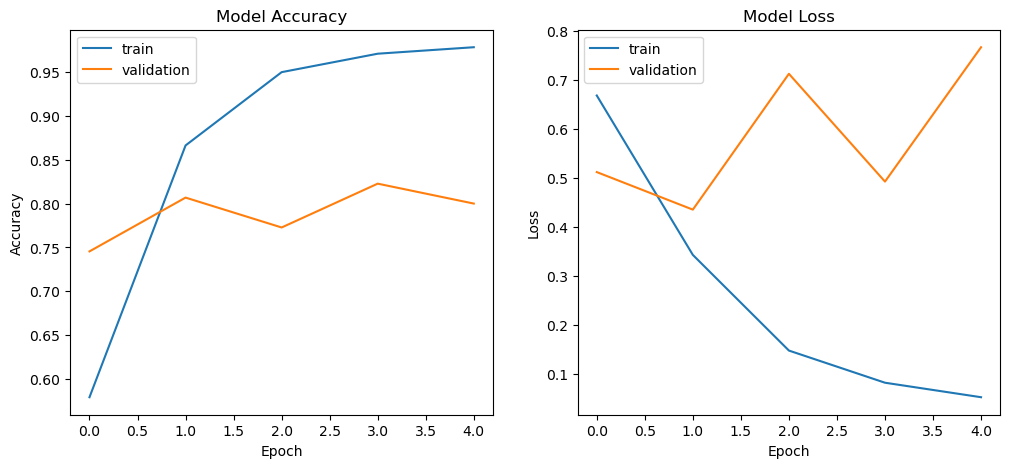

In [29]:
plt.figure(figsize=(12, 5)) #creates graphs for model accuracy and model loss

plt.subplot(1, 2, 1) #outputs model accuracy graph to the left
plt.plot(history.history['accuracy'], label='train') #plots accuracy and labels it train
plt.plot(history.history['val_accuracy'], label='validation') #plots val_accuracy and labels it validation
plt.title('Model Accuracy') #titles model accuracy graph
plt.xlabel('Epoch') #titles x-axis
plt.ylabel('Accuracy') #titles y-axis
plt.legend() #adds legend

plt.subplot(1, 2, 2) #outputs model loss graph to the right
plt.plot(history.history['loss'], label='train') #plots loss and labels it train
plt.plot(history.history['val_loss'], label='validation') #plots validation and labels it validation 
plt.title('Model Loss') #titles model loss graph
plt.xlabel('Epoch') #titles x-axis
plt.ylabel('Loss') #titles y-axis
plt.legend() #adds legend 

plt.show() #shows the graphs 

In [30]:
model.save('sentiment_model.keras') #saves the model